# Sprint10 DNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from numpy import linalg as LA
import copy
sns.set()
%matplotlib inline
import time
import math
import copy
import random

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# MNIST data set
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
X_train = X_train.reshape(-1, 784) #平滑化
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [4]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [5]:
X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


層などのクラス化
>クラスにまとめて行くことで、構成を変更しやすい実装にしていきます。
手を加える箇所
- 層の数
- 層の種類（今後畳み込み層など他のタイプの層が登場する）
- 活性化関数の種類
- 重みやバイアスの初期化方法
- 最適化手法

全結合層、各種活性化関数、重みやバイアスの初期化、最適化手法それぞれのクラスを作成します。

>サンプルコード1のように全結合層と活性化関数のインスタンスを作成し、サンプルコード2,3のようにして使用します。それぞれのクラスについてはこのあと解説します。

In [53]:
#《サンプルコード1》

# self.sigma : ガウス分布の標準偏差
# self.lr : 学習率
# self.n_nodes1 : 1層目のノード数
# self.n_nodes2 : 2層目のノード数
# self.n_output : 出力層のノード数

optimizer = SGD(self.lr)
self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
self.activation1 = Tanh()
self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
self.activation2 = Tanh()
self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
self.activation3 = Softmax()

NameError: name 'self' is not defined

In [54]:
#《サンプルコード2》
#イテレーションごとのフォワード

A1 = self.FC1.forward(X)
Z1 = self.activation1.forward(A1)
A2 = self.FC2.forward(Z1)
Z2 = self.activation2.forward(A2)
A3 = self.FC3.forward(Z2)
Z3 = self.activation3.forward(A3)

NameError: name 'self' is not defined

In [55]:
#《サンプルコード3》
#イテレーションごとのバックワード

dA3 = self.activation3.backward(Z3, Y) # 交差エントロピー誤差とソフトマックスを合わせている
dZ2 = self.FC3.backward(dA3)
dA2 = self.activation2.backward(dZ2)
dZ1 = self.FC2.backward(dA2)
dA1 = self.activation1.backward(dZ1)
dZ0 = self.FC1.backward(dA1) # dZ0は使用しない

NameError: name 'self' is not defined

## 【問題1】全結合層のクラス化

In [56]:
'''
コンストラクタで重みやバイアスの初期化
フォワードとバックワードのメソッドを用意
重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、
煩雑な入出力は不要に.

初期化方法のインスタンスinitializerをコンストラクタで受け取れば、
それにより初期化が行われます。
渡すインスタンスを変えれば、初期化方法が変えられます。

self.optimizer.update(self)という風に層の重みの更新が可能
更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。
'''

'\nコンストラクタで重みやバイアスの初期化\nフォワードとバックワードのメソッドを用意\n重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、\n煩雑な入出力は不要に.\n\n初期化方法のインスタンスinitializerをコンストラクタで受け取れば、\nそれにより初期化が行われます。\n渡すインスタンスを変えれば、初期化方法が変えられます。\n\nself.optimizer.update(self)という風に層の重みの更新が可能\n更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。\n'

In [275]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.Z = None
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.Z = X
        self.H_W = 0
        self.H_B = 0
        A = self.Z @ self.W + self.B #W(n_nodes1, n_nodes2),B(n_nodes2,)
        
        return A #出力 (batch_size, n_nodes2)
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dB = np.sum(dA,axis=0)
        self.dW = self.Z.T @ dA
        dZ = dA @ self.W.T
        
        # 更新
        self = self.optimizer.update(self) 
        return dZ

## 【問題2】初期化方法のクラス化
>全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。
これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

In [7]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, weight_type = 'sig', sigma=0.01):
        self.weight_type = weight_type
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        if self.weight_type == 'sig':
            W_std = self.sigma
        
        elif self.weight_type == 'xav':
            W_std = 1/np.sqrt(n_nodes1)
            
        elif self.weight_type == 'he':
            W_std = np.sqrt(2/n_nodes1)
            
        W = W_std * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(n_nodes2)
        return B

## 【問題3】最適化手法のクラス化
>最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself.optimizer.update(self)のように更新できるようにします。これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

In [46]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer): 
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        '''
        layer (FC)から持ってこれるようになる。
        layer.Z = FC内のself.Z
        layer.W
        layer.B
        '''
        layer.W = layer.W - self.lr * layer.dW
        layer.B = layer.B - self.lr * layer.dB

## 【問題4】活性化関数のクラス化
>ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。

In [204]:
#活性化関数や重みの初期値、最適化手法に関してこれまで見てきた以外のものを実装していきます。
class Softmax:
    def __init__(self):
        pass    

    def forward(self,A):
        if A.ndim == 2:
            x = A.T
            x = x - np.max(x, axis=0)
            y = np.exp(x) / np.sum(np.exp(x), axis=0)
            return y.T
        
#         x = A - np.max(A) 
        # オーバーフロー対策
#         Z_last = np.exp(A) / np.sum(np.exp(A))
        return np.exp(A) / np.sum(np.exp(A))
        
#         return Z_last
    
    def backward(self,Z_last,y):
        dA_last = Z_last - y #交差エントロピー誤差の計算も含む実装
        return dA_last

In [205]:
"""
合計が１になるか確認することが大切。
"""
soft_func = Softmax()
soft = np.sum(soft_func.forward(X_train),axis=1)
soft

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., ..., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

In [206]:
class Sigmoid:
    def __init__(self):
        self.A = None    

    def forward(self,A):
        self.A = A
        Z = 1/ (1+ np.exp(- self.A))
        return Z
    
    def backward(self,dZ):
        dA =dZ * ((1- (1/ (1+ np.exp(- self.A))))*(1/ (1+ np.exp(- self.A))))
        return dA

In [301]:
class Hipo:
    def __init__(self):
        self.A = None    

    def forward(self,A):
        self.A = A
        Z = np.tanh(self.A)
        return Z
    
    def backward(self,dZ):
        dA = dZ * ((np.tanh(self.A))**2)
        return dA

## 【問題5】ReLUクラスの作成
>数学的には微分可能ではないですが、 
x=0のとき 0とすることで対応しています。
フォワード時の x の正負により、勾配を逆伝播するかどうかが決まるということになります。

In [ ]:
class ReLU:
    """
    活性化関数 ReLU
    """
    def __init__(self):
        self.forward_A = None
    def forward(self, A):
        self.forward_A = A
        return np.maximum(A, 0)
    def backward(self, dZ):
        return dZ * np.where(self.forward_A>0, 1, 0)

In [300]:
# class ReLU:
#     """
#     ノード数n_nodes1からn_nodes2へのReLU
#     Parameters
#     ----------
#     n_nodes1 : int
#       前の層のノード数
#     n_nodes2 : int
#       後の層のノード数
#     """
#     def __init__(self):
#         pass
    
#     def forward(self, X):
#         """
#         フォワード
#         Parameters
#         ----------
#         X : 次の形のndarray, shape (batch_size, n_nodesX)
#             入力
#         Returns
#         ----------
#         Z : 次の形のndarray, shape (batch_size, n_nodesX)
#             出力
#         """     
#         #各要素について、負の値のみ０に置換したい。np.maximum
#         return np.maximum(X,0)
    
#     def backward(self, dA):
#         """
#         バックワード
#         Parameters
#         ----------
#         dA : 次の形のndarray, shape (batch_size, n_nodes2)
#             後ろから流れてきた勾配
#         Returns
#         ----------
#         dZ : 
#             前に流す勾配　#(batch_size, n_nodes2)
#         """
#         #各要素について、正の値を１、負の値を０に置換したい。
#         dZ = np.maximum(dA,np.zeros_like(dA))
#         #負の値は-1、正の値は1、0は0となるnumpy.ndarrayが返される。
#         return np.sign(dZ) 

## 【問題6】重みの初期値
>シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。
XavierInitializerクラスと、HeInitializerクラスを作成してください。

Xavierの初期値

In [153]:
if weight_type == 'xav':
    W_std = 1/np.sqrt(n_nodes1)
    W = W_std * np.random.randn(n_nodes1, n_nodes2)

NameError: name 'weight_type' is not defined

Heの初期値

In [63]:
if weight_type == 'he':
    W_std = np.sqrt(2/n_nodes1)
    W = W_std * np.random.randn(n_nodes1, n_nodes2)

NameError: name 'weight_type' is not defined

## 【問題7】最適化手法
>AdaGrad のクラスを作成してください。

In [276]:
class AdaGrad:
    """
    AdaGrad
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        # ミニバッチ方向(axis=0)にベクトルの平均を計算 #(n_nodes1, n_nodes2)
        layer.H_W = layer.H_W + np.sum(layer.dW ** 2)
        layer.H_B = layer.H_B + np.sum(layer.dB ** 2)
        layer.W = layer.W - (self.lr * np.sqrt(1/layer.H_W)) * layer.dW
        layer.B = layer.B - (self.lr * np.sqrt(1/layer.H_B)) * layer.dB

## 【問題8】クラスの完成

In [180]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, 
                 seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

"""
以下スクラッチ
"""
class ScratchDeepNeuralNetrowkClassifier():
    """
    Deep Neural Netrowk 分類器

    Parameters
    ------    

    Attributes
    ----------
    """

    def __init__(self, max_iter=5,
                 lr=0.01, sigma = 0.01,
                 verbose = True):
        """
        self.sigma : ガウス分布の標準偏差
        self.lr : 学習率
        self.iter : 学習回数
        """
        self.iter = max_iter
        self.lr = lr
        self.sigma = sigma
        self.verbose = verbose
    
    def loss_func(self,y,y_pred_proba):
        sigma_c = np.sum(y * np.log(y_pred_proba), axis = 1) 
        #batch_size方向に平均
        return -np.mean(sigma_c)
    
    def fit(self, X, y,
            sigma = 0.01,n_nodes1 = 400,n_nodes2 = 200,
            n_output = 10, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        
        # self.n_nodes1 : 1層目のノード数
        # self.n_nodes2 : 2層目のノード数
        # self.n_output : 出力層のノード数

        """
        self.n_features = X.shape[1]
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        
        optimizer = SGD(self.lr) #更新方法選択
        
        self.FC1 = FC(self.n_features, self.n_nodes1,
                      SimpleInitializer(weight_type='xav',sigma = self.sigma),optimizer)
        self.activation1 = Sigmoid()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, 
                      SimpleInitializer(weight_type='xav',sigma = self.sigma),optimizer)
        self.activation2 = Sigmoid()
        self.FC3 = FC(self.n_nodes2, self.n_output, 
                      SimpleInitializer(weight_type='xav',sigma = self.sigma),optimizer)
        self.activation3 = Softmax()
        self.loss = None
        
        for n in range(self.iter): #何回回そう？ MNISTなら50回ほどで試す
            get_mini_batch = GetMiniBatch(X_train,
                                          y_train_one_hot,
                                          batch_size=20)
            for mini_X_train, mini_y_train in get_mini_batch:
            # このfor文内でミニバッチが使える
                #W,B = FC内 FCX.W, FCX.B (Xは1,2,...)
                A1 = self.FC1.forward(mini_X_train) #(batch_size, n_nodes1)
                Z1 = self.activation1.forward(A1) #(batch_size, n_nodes1)
                A2 = self.FC2.forward(Z1) #(batch_size, n_nodes2)
                Z2 = self.activation2.forward(A2) #(batch_size, n_nodes2)
                A3 = self.FC3.forward(Z2) #(batch_size, n_output)
                Z3 = self.activation3.forward(A3) #(batch_size, n_output)                
                
                dA3 = self.activation3.backward(Z3, mini_y_train) #(batch_size, n_output)
                # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3) #(batch_size, n_nodes2)
                dA2 = self.activation2.backward(dZ2) #(batch_size, n_nodes2)
                dZ1 = self.FC2.backward(dA2) #(batch_size, n_nodes1)
                dA1 = self.activation1.backward(dZ1) #(batch_size, n_nodes1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
            
            A1 = self.FC1.forward(X) #(sample_size, n_nodes1)
            Z1 = self.activation1.forward(A1) #(sample_size, n_nodes1)
            A2 = self.FC2.forward(Z1) #(sample_size, n_nodes2)
            Z2 = self.activation2.forward(A2) #(sample_size, n_nodes2)
            A3 = self.FC3.forward(Z2) #(sample_size, n_output)
            Z3 = self.activation3.forward(A3) #(sample_size, n_output)
            y_pred_proba = Z3
            loss = self.loss_func(y,y_pred_proba)
            self.loss = np.append(self.loss,loss)
            
        self.loss = np.delete(self.loss, 0)
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print("self.loss.shape",self.loss.shape)
                
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        A1 = self.FC1.forward(X) #(n_samples, n_nodes1)
        Z1 = self.activation1.forward(A1) #(n_samples, n_nodes1)
        A2 = self.FC2.forward(Z1) #(n_samples, n_nodes2)
        Z2 = self.activation2.forward(A2) #(n_samples, n_nodes2)
        A3 = self.FC3.forward(Z2) #(n_samples, n_output)
        Z3 = self.activation3.forward(A3) #(n_samples, n_output)

        y_pred_proba = np.argmax(Z3,axis=1)
        return y_pred_proba

In [252]:
DNN = ScratchDeepNeuralNetrowkClassifier(max_iter=100,
                                         lr=0.001, sigma = 0.01,
                                         verbose = True)

In [171]:
y_train_one_hot.shape #(48000, 10)

(48000, 10)

## 【問題9】学習と推定


In [254]:
t1 = time.time()
DNN.fit(X_train, y_train_one_hot)

t2 = time.time()
print("processing time:",t2-t1)

self.loss.shape (100,)
processing time: 553.1138107776642


In [255]:
DNN.loss

array([1.0518611142643464, 0.5404967505158068, 0.4216621337336889,
       0.3732944759733351, 0.34655946856021674, 0.3282297975896323,
       0.3140816922916907, 0.302392898968385, 0.29229118949698024,
       0.2832723542955686, 0.2750233513359937, 0.26733770377643,
       0.2600704951997984, 0.2531161784947585, 0.24639857324353656,
       0.2398656193386318, 0.23348519378537905, 0.2272409017613139,
       0.22112785177585034, 0.2151486943923876, 0.20931018632081216,
       0.20362048186133727, 0.19808728578571708, 0.19271684536835804,
       0.1875135711119285, 0.18248001472498435, 0.17761700431117625,
       0.17292383032851152, 0.16839843451943917, 0.1640375859310984,
       0.1598370482865995, 0.15579175190847283, 0.15189597920697118,
       0.14814356140712343, 0.14452807504807755, 0.14104302400046625,
       0.1376819947748953, 0.13443877710753613, 0.13130744669426914,
       0.1282824115570603, 0.12535842709946637, 0.122530587143986,
       0.11979429925867263, 0.117145252542347

In [256]:
y_pred = DNN.predict(X_test)

np.set_printoptions(edgeitems= 10)
print(pd.Series(y_pred).value_counts())

print(y_pred)

print("accuracy",accuracy_score(np.argmax(y_test_one_hot,axis=1),y_pred))


1    1142
2    1037
7    1026
3    1021
9    1016
0     991
4     970
8     965
6     960
5     872
dtype: int64
[7 2 1 0 4 1 4 9 6 9 ... 7 8 9 0 1 2 3 4 5 6]
accuracy 0.9723


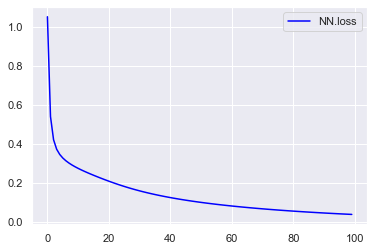

In [257]:
plt.plot(DNN.loss,label='NN.loss', color = 'blue')
# plt.plot(slr.val_loss,label='slr.val_loss', color = 'orange')
plt.grid(True)                                 # グリッド線を表示
plt.legend()

In [277]:
"""
以下スクラッチ AdaGrad
"""
class ScratchDeepNeuralNetrowkClassifier3():
    """
    Deep Neural Netrowk 分類器

    Parameters
    ------    

    Attributes
    ----------
    """

    def __init__(self, max_iter=5,
                 lr=0.01, sigma = 0.01,
                 verbose = True):
        """
        self.sigma : ガウス分布の標準偏差
        self.lr : 学習率
        self.iter : 学習回数
        """
        self.iter = max_iter
        self.lr = lr
        self.sigma = sigma
        self.verbose = verbose
    
    def loss_func(self,y,y_pred_proba):
        sigma_c = np.sum(y * np.log(y_pred_proba), axis = 1) 
        #batch_size方向に平均
        return -np.mean(sigma_c)
    
    def fit(self, X, y,
            sigma = 0.01,n_nodes1 = 400,n_nodes2 = 200,
            n_output = 10, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        
        # self.n_nodes1 : 1層目のノード数
        # self.n_nodes2 : 2層目のノード数
        # self.n_output : 出力層のノード数

        """
        self.n_features = X.shape[1]
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        
        optimizer = AdaGrad(self.lr) #更新方法選択
        
        self.FC1 = FC(self.n_features, self.n_nodes1,
                      SimpleInitializer(weight_type='xav',sigma = self.sigma),optimizer)
        self.activation1 = Sigmoid()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, 
                      SimpleInitializer(weight_type='xav',sigma = self.sigma),optimizer)
        self.activation2 = Sigmoid()
        self.FC3 = FC(self.n_nodes2, self.n_output, 
                      SimpleInitializer(weight_type='xav',sigma = self.sigma),optimizer)
        self.activation3 = Softmax()
        self.loss = None
        
        for n in range(self.iter): #何回回そう？ MNISTなら50回ほどで試す
            get_mini_batch = GetMiniBatch(X_train,
                                          y_train_one_hot,
                                          batch_size=20)
            for mini_X_train, mini_y_train in get_mini_batch:
            # このfor文内でミニバッチが使える
                #W,B = FC内 FCX.W, FCX.B (Xは1,2,...)
                A1 = self.FC1.forward(mini_X_train) #(batch_size, n_nodes1)
                Z1 = self.activation1.forward(A1) #(batch_size, n_nodes1)
                A2 = self.FC2.forward(Z1) #(batch_size, n_nodes2)
                Z2 = self.activation2.forward(A2) #(batch_size, n_nodes2)
                A3 = self.FC3.forward(Z2) #(batch_size, n_output)
                Z3 = self.activation3.forward(A3) #(batch_size, n_output)                
                
                dA3 = self.activation3.backward(Z3, mini_y_train) #(batch_size, n_output)
                # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3) #(batch_size, n_nodes2)
                dA2 = self.activation2.backward(dZ2) #(batch_size, n_nodes2)
                dZ1 = self.FC2.backward(dA2) #(batch_size, n_nodes1)
                dA1 = self.activation1.backward(dZ1) #(batch_size, n_nodes1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
            
            A1 = self.FC1.forward(X) #(sample_size, n_nodes1)
            Z1 = self.activation1.forward(A1) #(sample_size, n_nodes1)
            A2 = self.FC2.forward(Z1) #(sample_size, n_nodes2)
            Z2 = self.activation2.forward(A2) #(sample_size, n_nodes2)
            A3 = self.FC3.forward(Z2) #(sample_size, n_output)
            Z3 = self.activation3.forward(A3) #(sample_size, n_output)
            y_pred_proba = Z3
            loss = self.loss_func(y,y_pred_proba)
            self.loss = np.append(self.loss,loss)
            
        self.loss = np.delete(self.loss, 0)
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print("self.loss.shape",self.loss.shape)
                
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        A1 = self.FC1.forward(X) #(n_samples, n_nodes1)
        Z1 = self.activation1.forward(A1) #(n_samples, n_nodes1)
        A2 = self.FC2.forward(Z1) #(n_samples, n_nodes2)
        Z2 = self.activation2.forward(A2) #(n_samples, n_nodes2)
        A3 = self.FC3.forward(Z2) #(n_samples, n_output)
        Z3 = self.activation3.forward(A3) #(n_samples, n_output)

        y_pred_proba = np.argmax(Z3,axis=1)
        return y_pred_proba

In [283]:
DNN3 = ScratchDeepNeuralNetrowkClassifier3(max_iter=100,
                                           lr=0.001, sigma = 0.01,
                                           verbose = True)

In [284]:
t1 = time.time()
DNN3.fit(X_train, y_train_one_hot)

t2 = time.time()
print("processing time:",t2-t1)

self.loss.shape (100,)
processing time: 652.7957491874695


In [285]:
y_pred = DNN3.predict(X_test)

np.set_printoptions(edgeitems= 10)
print(pd.Series(y_pred).value_counts())

print(y_pred)

print("accuracy",accuracy_score(np.argmax(y_test_one_hot,axis=1),y_pred))


1    1147
0    1024
4    1012
7    1009
2    1006
9     996
3     995
8     973
6     967
5     871
dtype: int64
[7 2 1 0 4 1 4 9 6 9 ... 7 8 9 0 1 2 3 4 5 6]
accuracy 0.9216


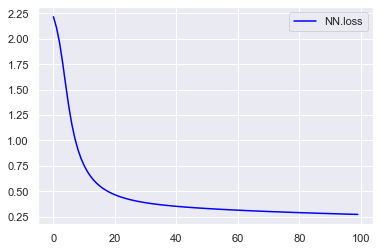

In [286]:
plt.plot(DNN3.loss,label='NN.loss', color = 'blue')
# plt.plot(slr.val_loss,label='slr.val_loss', color = 'orange')
plt.grid(True)                                 # グリッド線を表示
plt.legend()

In [302]:
"""
以下スクラッチ ReLU版
"""
class ScratchDeepNeuralNetrowkClassifier2():
    """
    Deep Neural Netrowk 分類器

    Parameters
    ------    

    Attributes
    ----------
    """

    def __init__(self, max_iter=5,
                 lr=0.01, sigma = 0.01,
                 verbose = True):
        """
        self.sigma : ガウス分布の標準偏差
        self.lr : 学習率
        self.iter : 学習回数
        """
        self.iter = max_iter
        self.lr = lr
        self.sigma = sigma
        self.verbose = verbose
    
    def loss_func(self,y,y_pred_proba):
        sigma_c = np.sum(y * np.log(y_pred_proba), axis = 1) 
        #batch_size方向に平均
        return -np.mean(sigma_c)
    
    def fit(self, X, y,
            sigma = 0.01,n_nodes1 = 400,n_nodes2 = 200,
            n_output = 10, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        
        # self.n_nodes1 : 1層目のノード数
        # self.n_nodes2 : 2層目のノード数
        # self.n_output : 出力層のノード数

        """
        self.n_features = X.shape[1]
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        
        #initializer = SimpleInitializer(weight_type='xav',sigma = self.sigma)
        optimizer = AdaGrad(self.lr) #更新方法選択
        
        self.FC1 = FC(self.n_features, self.n_nodes1,
                      SimpleInitializer(weight_type='he',sigma = self.sigma),optimizer)
        self.activation1 = ReLU()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, 
                      SimpleInitializer(weight_type='he',sigma = self.sigma),optimizer)
        self.activation2 = ReLU()
        self.FC3 = FC(self.n_nodes2, self.n_output, 
                      SimpleInitializer(weight_type='he',sigma = self.sigma),optimizer)
        self.activation3 = Softmax()
        
        self.loss = None
        
        for n in range(self.iter): #何回回そう？ MNISTなら50回ほどで試す
            get_mini_batch = GetMiniBatch(X_train,
                                          y_train_one_hot,
                                          batch_size=20)
            for mini_X_train, mini_y_train in get_mini_batch:
            # このfor文内でミニバッチが使える
                #W,B = FC内 FCX.W, FCX.B (Xは1,2,...)
                A1 = self.FC1.forward(mini_X_train) #(batch_size, n_nodes1)
                Z1 = self.activation1.forward(A1) #(batch_size, n_nodes1)
                A2 = self.FC2.forward(Z1) #(batch_size, n_nodes2)
                Z2 = self.activation2.forward(A2) #(batch_size, n_nodes2)
                A3 = self.FC3.forward(Z2) #(batch_size, n_output)
                Z3 = self.activation3.forward(A3) #(batch_size, n_output)                
                
                dA3 = self.activation3.backward(Z3, mini_y_train) #(batch_size, n_output)
                # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3) #(batch_size, n_nodes2)
                dA2 = self.activation2.backward(dZ2) #(batch_size, n_nodes2)
                dZ1 = self.FC2.backward(dA2) #(batch_size, n_nodes1)
                dA1 = self.activation1.backward(dZ1) #(batch_size, n_nodes1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
            
            A1 = self.FC1.forward(X) #(sample_size, n_nodes1)
            Z1 = self.activation1.forward(A1) #(sample_size, n_nodes1)
            A2 = self.FC2.forward(Z1) #(sample_size, n_nodes2)
            Z2 = self.activation2.forward(A2) #(sample_size, n_nodes2)
            A3 = self.FC3.forward(Z2) #(sample_size, n_output)
            Z3 = self.activation3.forward(A3) #(sample_size, n_output)
            y_pred_proba = Z3
            loss = self.loss_func(y,y_pred_proba)
            self.loss = np.append(self.loss,loss)
            
        self.loss = np.delete(self.loss, 0)
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print("self.loss.shape",self.loss.shape)
                
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        A1 = self.FC1.forward(X) #(n_samples, n_nodes1)
        Z1 = self.activation1.forward(A1) #(n_samples, n_nodes1)
        A2 = self.FC2.forward(Z1) #(n_samples, n_nodes2)
        Z2 = self.activation2.forward(A2) #(n_samples, n_nodes2)
        A3 = self.FC3.forward(Z2) #(n_samples, n_output)
        Z3 = self.activation3.forward(A3) #(n_samples, n_output)

        y_pred_proba = np.argmax(Z3,axis=1)
        return y_pred_proba

In [303]:
DNN2 = ScratchDeepNeuralNetrowkClassifier2(max_iter=10,
                                         lr=0.00001, sigma = 0.01,
                                         verbose = True)

In [304]:
t1 = time.time()
DNN2.fit(X_train, y_train_one_hot)

t2 = time.time()
print("processing time:",t2-t1)

self.loss.shape (10,)
processing time: 53.36805295944214


In [305]:
DNN2.loss

array([2.3079340951887635, 2.2968406613588606, 2.287435515935121,
       2.279433338429125, 2.2726163892783173, 2.266795247414147,
       2.2618161941710198, 2.2575550482479314, 2.2538835507614086,
       2.2507360680714217], dtype=object)

In [306]:
y_pred = DNN2.predict(X_test)

np.set_printoptions(edgeitems= 10)
print(pd.Series(y_pred).value_counts())

print(y_pred)

print("accuracy",accuracy_score(np.argmax(y_test_one_hot,axis=1),y_pred))


3    3448
8    1991
0    1247
7    1077
2     662
9     515
5     466
4     428
6     124
1      42
dtype: int64
[3 0 8 3 3 7 8 3 8 4 ... 8 3 4 3 4 0 3 7 0 3]
accuracy 0.1547


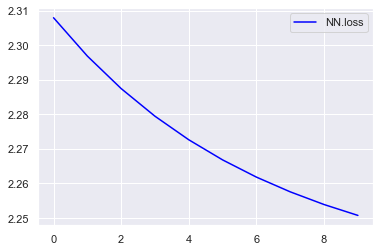

In [307]:
plt.plot(DNN2.loss,label='NN.loss', color = 'blue')
# plt.plot(slr.val_loss,label='slr.val_loss', color = 'orange')
plt.grid(True)                                 # グリッド線を表示
plt.legend()